In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
path = glob('../input/car-plate-detection/annotations/*.xml')
label_dict = {"filepath" : [] ,"xmin" :[] , "xmax" :[] , "ymin" :[] , "ymax" :[]}

for p in path :
    info = xet.parse(p)
    root = info.getroot()
    member =  root.find('object')
    labels_info = member.find('bndbox')
    label_dict['filepath'].append(p)
    label_dict['xmin'].append(int(labels_info.find('xmin').text))
    label_dict['xmax'].append(int(labels_info.find('xmax').text))
    label_dict['ymin'].append(int(labels_info.find('ymin').text))
    label_dict['ymax'].append(int(labels_info.find('ymax').text))
    

In [4]:
dataset =  pd.DataFrame(label_dict)
dataset.to_csv("labels.csv",index = False)
dataset.head()

,filepath,xmin,xmax,ymin,ymax
0,../input/car-plate-detection/annotations/Cars3...,209,283,135,169
1,../input/car-plate-detection/annotations/Cars1...,191,242,147,169
2,../input/car-plate-detection/annotations/Cars7...,115,277,115,153
3,../input/car-plate-detection/annotations/Cars1...,36,62,175,186
4,../input/car-plate-detection/annotations/Cars2...,71,215,205,246


In [5]:
def get_filename(element):
    file =  xet.parse(element).getroot().find('filename').text
    #print(file)
    imagepath = os.path.join('../input/car-plate-detection/images',file)
    return imagepath

imagepath =  list(dataset['filepath'].apply(get_filename))
imagepath[:10]

['../input/car-plate-detection/images/Cars339.png',
 '../input/car-plate-detection/images/Cars13.png',
 '../input/car-plate-detection/images/Cars74.png',
 '../input/car-plate-detection/images/Cars16.png',
 '../input/car-plate-detection/images/Cars291.png',
 '../input/car-plate-detection/images/Cars236.png',
 '../input/car-plate-detection/images/Cars429.png',
 '../input/car-plate-detection/images/Cars132.png',
 '../input/car-plate-detection/images/Cars251.png',
 '../input/car-plate-detection/images/Cars51.png']

In [6]:
labels = dataset.iloc[:,1:].values
data = []
output =[]

for index in range(len(imagepath)):
    
    img =  imagepath[index]
    image = cv2.imread(img)
    h,w,d =  image.shape
    
    load_image = load_img(img,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255
    data.append(norm_load_image_arr)
    
    xmin,xmax,ymin,ymax = labels[index]
    labels_norm = (xmin/w,xmax/w,ymin/h,ymax/h)
    output.append(labels_norm)
    
x = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)


In [7]:
print(len(x))
print(len(y))

433
433


In [8]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

In [9]:
inception = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))

out = inception.output
out = Flatten()(out)
out = Dense(500,activation="relu")(out)
out = Dense(250,activation="relu")(out)
out = Dense(4,activation='sigmoid')(out)

model = Model(inputs = inception.input , outputs =out)

2022-10-03 12:05:22.936363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 12:05:22.939967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 12:05:22.940726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 12:05:22.941887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 8s 0us/step


In [10]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=180,
                    validation_data=(x_test,y_test),callbacks=[tfb])

2022-10-03 12:05:38.585824: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-03 12:05:38.585860: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-03 12:05:38.587726: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-10-03 12:05:38.891180: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-03 12:05:38.891335: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-03 12:05:39.800455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/180


2022-10-03 12:05:56.934378: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/35 [..............................] - ETA: 13:19 - loss: 0.0509

2022-10-03 12:06:03.821093: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-03 12:06:03.821145: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/35 [>.............................] - ETA: 36s - loss: 0.0612  

2022-10-03 12:06:04.482712: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-03 12:06:04.487185: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-03 12:06:04.681553: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5168 callback api events and 5166 activity events. 
2022-10-03 12:06:04.805330: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-03 12:06:04.952357: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: object_detection/train/plugins/profile/2022_10_03_12_06_04

2022-10-03 12:06:05.049853: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to object_detection/train/plugins/profile/2022_10_03_12_06_04/a802cec6776a.trace.json.gz
2022-10-03 12:06:05.254236: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating 

35/35 [==============================] - 35s 342ms/step - loss: 0.0519 - val_loss: 0.0289
Epoch 2/180
35/35 [==============================] - 6s 178ms/step - loss: 0.0187 - val_loss: 0.0272
Epoch 3/180
35/35 [==============================] - 6s 176ms/step - loss: 0.0091 - val_loss: 0.0130
Epoch 4/180
35/35 [==============================] - 6s 174ms/step - loss: 0.0064 - val_loss: 0.0113
Epoch 5/180
35/35 [==============================] - 7s 197ms/step - loss: 0.0037 - val_loss: 0.0123
Epoch 6/180
35/35 [==============================] - 6s 180ms/step - loss: 0.0037 - val_loss: 0.0126
Epoch 7/180
35/35 [==============================] - 6s 178ms/step - loss: 0.0028 - val_loss: 0.0122
Epoch 8/180
35/35 [==============================] - 6s 176ms/step - loss: 0.0026 - val_loss: 0.0113
Epoch 9/180
35/35 [==============================] - 6s 173ms/step - loss: 0.0024 - val_loss: 0.0113
Epoch 10/180
35/35 [==============================] - 6s 184ms/step - loss: 0.0024 - val_loss: 0.0106


In [11]:
model.save('./object_detection.h5')


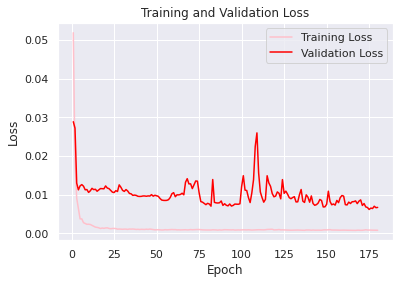

In [12]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


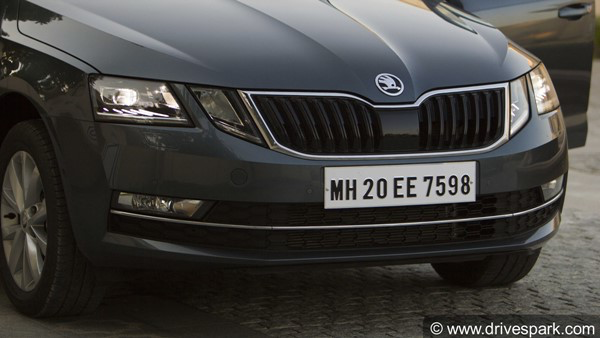

In [13]:
path = '../input/car-plate-detection/images/Cars111.png'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) 
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255
h,w,d = image.shape

fig = px.imshow(image)
fig.show()

In [14]:
image_arr_224.shape

(224, 224, 3)

In [15]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [16]:
pred =  model.predict(test_arr)
pred

array([[0.5468759 , 0.8012219 , 0.49475962, 0.61678386]], dtype=float32)

In [17]:
denorm = np.array([w,w,h,h])
coords = pred * denorm
coords

array([[328.12553644, 480.73314428, 167.2287513 , 208.47294378]])

In [18]:
coords = coords.astype(np.int32)
coords

array([[328, 480, 167, 208]], dtype=int32)

In [19]:
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)


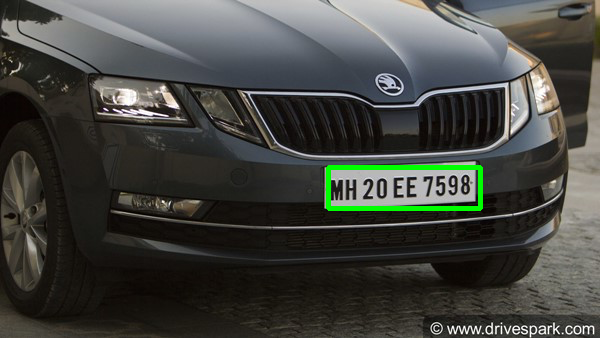

In [20]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.show()

In [21]:
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'../input/car-plate-detection/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
dataset[['filename','width','height']] = dataset['filepath'].apply(parsing).apply(pd.Series)
dataset.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,../input/car-plate-detection/annotations/Cars3...,209,283,135,169,../input/car-plate-detection/images/Cars339.png,500,300
1,../input/car-plate-detection/annotations/Cars1...,191,242,147,169,../input/car-plate-detection/images/Cars13.png,400,268
2,../input/car-plate-detection/annotations/Cars7...,115,277,115,153,../input/car-plate-detection/images/Cars74.png,400,267
3,../input/car-plate-detection/annotations/Cars1...,36,62,175,186,../input/car-plate-detection/images/Cars16.png,400,221
4,../input/car-plate-detection/annotations/Cars2...,71,215,205,246,../input/car-plate-detection/images/Cars291.png,517,303


In [22]:
dataset['center_x'] = (dataset['xmax'] + dataset['xmin'])/(2*dataset['width'])
dataset['center_y'] = (dataset['ymax'] + dataset['ymin'])/(2*dataset['height'])

dataset['bb_width'] = (dataset['xmax'] - dataset['xmin'])/dataset['width']
dataset['bb_height'] = (dataset['ymax'] - dataset['ymin'])/dataset['height']
dataset.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,../input/car-plate-detection/annotations/Cars3...,209,283,135,169,../input/car-plate-detection/images/Cars339.png,500,300,0.492000,0.506667,0.14800,0.113333
1,../input/car-plate-detection/annotations/Cars1...,191,242,147,169,../input/car-plate-detection/images/Cars13.png,400,268,0.541250,0.589552,0.12750,0.082090
2,../input/car-plate-detection/annotations/Cars7...,115,277,115,153,../input/car-plate-detection/images/Cars74.png,400,267,0.490000,0.501873,0.40500,0.142322
3,../input/car-plate-detection/annotations/Cars1...,36,62,175,186,../input/car-plate-detection/images/Cars16.png,400,221,0.122500,0.816742,0.06500,0.049774
4,../input/car-plate-detection/annotations/Cars2...,71,215,205,246,../input/car-plate-detection/images/Cars291.png,517,303,0.276596,0.744224,0.27853,0.135314


In [23]:
!git clone https://github.com/ultralytics/yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 13127, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 13127 (delta 193), reused 219 (delta 150), pack-reused 12844
Receiving objects: 100% (13127/13127), 13.11 MiB | 8.57 MiB/s, done.
Resolving deltas: 100% (9026/9026), done.


In [24]:
!pip install -r ./yolov5/requirements.txt


In [25]:
mkdir /kaggle/working/yolov5/data_images/


In [26]:
mkdir /kaggle/working/yolov5/data_images/test/

In [27]:
mkdir /kaggle/working/yolov5/data_images/train/


In [28]:
### split the data into train and test
df_train = dataset.iloc[:200]
df_test = dataset.iloc[200:]

In [29]:
train_folder = './yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

In [30]:
test_folder = './yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

In [31]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=6cb3163cfed766d1e6294d59fe23a1a5f3e9c154964c6b77b7d432e7a97119cf
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  2% |


In [32]:
!python ./yolov5/train.py --data ../input/numberplatedetection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=../input/numberplatedetection/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-182-g1158a50 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100

In [33]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx


export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v6.2-182-g1158a50 Python-3.7.12 torch-1.11.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 1.11.0...
TorchScript: export success ✅ 2.3s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.12.0...
ONNX: export success ✅ 2.8s, saved as yolov5/runs/train/Model/weights/best.onnx (27.2 MB)

Export complete (5.8s)
Results saved to /kaggle/w

In [43]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img ,detections


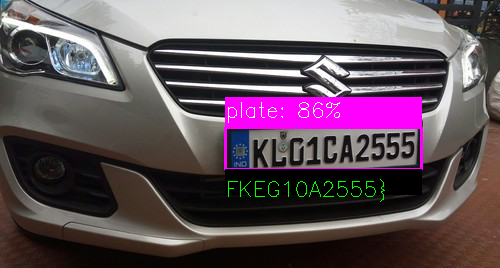

In [35]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
INPUT_WIDTH =  640
INPUT_HEIGHT = 640
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return 'no number'
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text
# test
img = io.imread('../input/car-plate-detection/images/Cars0.png')
results = yolo_predictions(img,net)
fig = px.imshow(img)
fig.show()

[[4.7398071e+00 9.6140471e+00 2.7643105e+01 3.1396843e+01 9.6509293e-06
  9.9994278e-01]
 [1.1653748e+01 1.0380927e+01 3.6515144e+01 3.2373550e+01 5.8079654e-06
  9.9995267e-01]
 [1.8920906e+01 1.0150909e+01 3.8659672e+01 3.3058617e+01 1.6578251e-06
  9.9996948e-01]
 ...
 [5.5875653e+02 6.2087878e+02 2.7578671e+02 1.9721378e+02 2.5979472e-05
  9.9997354e-01]
 [5.8114227e+02 6.2121863e+02 2.4925888e+02 1.8354311e+02 2.4339017e-05
  9.9997735e-01]
 [6.1613123e+02 6.2417706e+02 2.7430548e+02 1.9637300e+02 1.7312548e-05
  9.9998033e-01]]



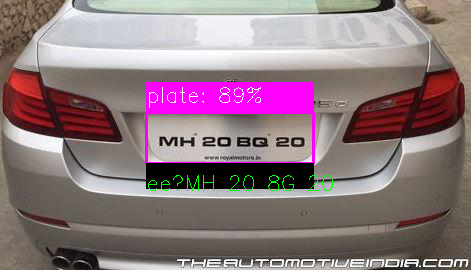

In [47]:
# test
img = io.imread('../input/car-plate-detection/images/Cars107.png')
results ,boxes_np = yolo_predictions(img,net)
#print(boxes_np)
fig = px.imshow(img)
fig.show()